# Import and Clean DS

In [106]:
import pandas as pd
import boto3
import glob
import io
import re
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


from sklearn.cluster import DBSCAN
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
import fr_core_news_sm
from s3_credentials import *
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import RepeatedStratifiedKFold

In [29]:
cd '/Users/admin/Jedha/'

/Users/admin/Jedha


In [30]:
# connect to s3 instance

#YOUR_ACCESS_KEY = 
#YOUR_SECRET_KEY = 

session = boto3.Session(aws_access_key_id= YOUR_ACCESS_KEY, 
                        aws_secret_access_key= YOUR_SECRET_KEY)

s3 = session.resource("s3")
client = session.client("s3")

In [31]:
#full DS
obj = s3.Object('jedha-fake-reviews-project', "datasets/full_dataset.csv")
dataset = pd.read_csv(io.BytesIO(obj.get()['Body'].read()), low_memory = False, index_col=0)

In [32]:

######### Cleaning the dataset and adding new columns #########

#we drop rows in which restaurant infos are not available (miss scraped)
dataset = dataset.dropna(subset = ['restaurant_average_rating', 'restaurant_reviews_count', 'restaurant_expensiveness', 'restaurant_name'])
#adding a column with the length of the text review
dataset['text_length'] = dataset['text_review'].apply(lambda x : len(x))


######### Fixing existing columns values and types #########

#for the user_total_image_posted column, if user_total_image_posted is NA it means there's no image found
# so we set the value to 0
dataset.loc[dataset['user_total_image_posted'].isna(), 'user_total_image_posted'] = 0

#for the date column,  there is some miss scrapped data that we want to fix
# a correct data must have a length of 10 , if it is smaller than 10 it's because we scrapped the number of images of the user instead
# we may have to scrap again those lines to fix it
# for now, we keep only the rows where the date is correct 
mask_not_date = dataset['date'].apply(lambda x: len(x)) < 10
dataset = dataset.loc[mask_not_date == False, :]
# if te length is greater than 10 is it is beacause we scraped the date + somme additional words ('Avis mis à jour') so we will keep only the part with the date
mask_date_to_fix = dataset['date'].apply(lambda x: len(x)) > 10
dataset.loc[mask_date_to_fix, 'date' ] = dataset.loc[mask_date_to_fix, 'date' ].str.split('\n').str[0]
#finally we can convert the date column to a datetime format
dataset['date'] = pd.to_datetime(dataset['date'])

#for the language column,
# We set all languages other than fr and eu to other to avoiding having lots of categories (causing troubles with OneHotEncoder)
mask_is_not_fr_en = (dataset['language'] != 'fr') & (dataset['language'] != 'en')
dataset.loc[mask_is_not_fr_en ,'language'] = 'other'

#for the username column,
# Setting Not Yelp User = 'Not_Yelp_User
dataset.loc[dataset['username'] == 'Not Yelp User', 'username' ] = 'Not_Yelp_User'

#for the photos_for_review column, 
# value -1 is in fact 0 (no photos found by the scraper)
dataset.loc[dataset['photos_for_review'] == '-1.0', 'photos_for_review' ] = '0'
# value L is in fact 0 (no photos found by the scraper but scraped the first letter of "L'avis du jour" which happens when the reviews was updated by the user)
dataset.loc[dataset['photos_for_review'] == 'L', 'photos_for_review' ] = '0'
# finally we can convert the photos_for_review column to an int format
dataset['photos_for_review'] = dataset['photos_for_review'].astype('int')

#for the photos_for_review column, 
# when there's no info about the expensiveness we set it to -1
dataset.loc[dataset['restaurant_expensiveness'] == 'N/C', 'restaurant_expensiveness']  = -1
# we can convert the restaurant_expensiveness column to an int format
dataset['restaurant_expensiveness'] = dataset['restaurant_expensiveness'].astype('int')

#for the is_real_review column, 
# when reverse the values 0 and 1 and rename the column is_fake_review it will make our work easier with sklearn features
dataset['is_real_review'] = dataset['is_real_review'].apply(lambda x: 1 if x == 0 else 0)
dataset.rename(columns={'is_real_review': 'is_fake_review'}, inplace=True)


dataset = dataset.reset_index(drop = True)

In [33]:
french_reviews = dataset.loc[dataset['language'] =='fr',['text_review', 'is_fake_review']].reset_index(drop=True)

# Preprocessing for NLP

## Cleaning the text

### Remove multiple punctuation and special characters 

In [34]:
def cleaner(x):
  #remove multiple punctuation
  x = re.sub(r"\.+", " . ", x)
  x = re.sub(r"\?+", " ? ", x)
  x = re.sub(r"!+", " ! ", x)
  x = re.sub(r"/", " ", x)

 #remove special char
  x = re.sub("&amp;", ' et ',x) 
  x = re.sub("&lt;", ' ',x)
  x = re.sub("&gt;", ' ',x)
  x = re.sub("\n", ' ',x)
  x = re.sub("=", ' ',x)
  x = re.sub("ª", ' ',x)
  x = re.sub("\|", ' ',x)
  x = re.sub("~", ' ',x)
  x = re.sub("{", ' ',x)
  x = re.sub("}", ' ',x)
  x = re.sub("\[", ' ',x)
  x = re.sub("\]", ' ',x)
  x = re.sub("\%", ' ',x)
  x = re.sub("\(", ' ',x)
  x = re.sub("\)", ' ',x)
  x = re.sub("\.", ' ',x)
  x = re.sub("\@.", ' ',x)
  x = re.sub("\:.", ' ',x)
  x = re.sub("©", ' ',x)
  x = re.sub("\*", ' ',x)
  x = re.sub("\=", ' ',x)
  x = re.sub(",", ' ',x)

  return x


### Expand contractions and abbreviations

In [35]:
def expand_text(x):

  #--Contractions--
  #expand negation
  x = re.sub("n'",'ne ', x) 
  #expand j'
  x = re.sub("j'",'je ', x) 
  #expand t'
  x = re.sub("t'",'te ', x) 
  #expand d'
  x = re.sub("d'",'de ', x) 
  #expand m'
  x = re.sub("m'",'me ', x)
  #expand c'
  x = re.sub("c'",'ceci ', x)  
  #expand l'
  x = re.sub("l'",'le ', x)
  #expand j'
  x = re.sub("j ",'je ', x)
  #expand n
  x = re.sub(" n ",' ne ', x)
  #expand qu'
  x = re.sub("qu'",'que ', x)

  #expand s'
  x = re.sub("s'",'se ', x)


  #--abbreviations --
  #expand €
  x = re.sub("€",' euros ', x)
  #expand $
  x = re.sub("\$",' dollars ', x)
  #expand nyc
  x = re.sub("\b(nyc)\b",' new york ', x)
  #expand m2
  x = re.sub("\b(m2)\b",' mètres carrés ', x)
  #expand m2
  x = re.sub("\b(m²)\b",' mètres carrés ', x) 
  #expand clt
  x = re.sub("\b(clt)\b",' client ', x)
  #expand QG
  x = re.sub("\b(qg)\b",' quartier général ', x)
  #expand hours, example 14h30 --> 14 heures 30
  x = re.sub("(?<=\d)[a-z]{1}", ' heures ', x)
  #expand - between numbers, example 2-3 € --> 2 à 3 euros
  x = re.sub("(?<=\d)[-]{1}(?=\d)", ' à ', x) 
  #expand / between numbers, example 2-3 € --> 2 à 3 euros
  x = re.sub("(?<=\d)[/]{1}(?=\d)", ' à ', x) 
  #expand district --> 11ème --> 11 ème arrondissement
  x = re.sub("(?<=\d)(ème)", ' ème arrondissement ', x)     


  #--fancy words--
  #whaow
  x = re.sub("\b(whaow)\w*", "waouh", x)

  #renoi
  x = re.sub("\b(renoi)\w*", "noire", x)

  #robeu
  x = re.sub("\b(robeu)\w*", "maghrébin", x)

  #rebeu
  x = re.sub("\b(rebeu)\w*", "maghrébin", x)

  #surkiff
  x = re.sub("\b(surkiff)\w*", "adore", x)

  #kiff
  x = re.sub("\b(kiff)\w*", "merveille", x)
 

  #survalide
  x = re.sub("\b(survalid)\w*", "merveille", x)

  #tuerie
  x = re.sub("tuerie", ' merveille ', x)    
  #brazil
  x = re.sub("brazil", ' brésil ', x)    
  return x

In [38]:
french_reviews["text_review_clean"] = french_reviews["text_review"].str.replace(r"[\n]", ' ').str.lower()
#expand contractions
french_reviews["text_review_clean"] = french_reviews["text_review_clean"].apply(lambda x: expand_text(x))
#remove special character and multiple occurences of a letter
french_reviews["text_review_clean"] = french_reviews["text_review_clean"].apply(lambda x: cleaner(x))
#remove multiple white spaces
french_reviews["text_review_clean"] = french_reviews["text_review_clean"].str.replace(r" +"," ")
#keep only alphanum or ! or ? or -
french_reviews["text_review_clean"] = french_reviews["text_review_clean"].apply(lambda x: "".join(ch for ch in x if ch.isalnum() or ch == '!' or ch =='?' or ch ==' ' or ch == '-' or ch =='%'))

### Dealing with fancy words (words with multiple repeat of a letter)



In [39]:
#replace fancy words example "coooool" turns into --> cool
def fix_fancy_words(x):  
  x = re.sub(r"\b(co+l+)\b", "cool", x)
  x = re.sub(r"\b(a+r+f+)\b", "décu", x)
  x = re.sub(r"\b(a+r+g+)\b", "décu", x)

  x = re.sub(r"\b(t+r+e{2,}s+)\b", "très !!", x)
  x = re.sub(r"\b(t+r+è{2,}s+)\b", "très !!", x)
  x = re.sub(r"\b(t+r+è+e{2,}s+)\b", "très !!", x)


  x = re.sub(r"\s(é+n+o{2,}r+m+e+)\w*", " énorme !!", x)
  x = re.sub(r"\b(e+n+o{2,}r+m+e+)\w*", "énorme !!", x)
  x = re.sub(r"\b(s+u{2,}p+e+r)\w*", "super !", x)

  x = re.sub(r"\b(l+o{2,}n+g+u+e+)\b", "longue !!", x)

  x = re.sub(r"\b(h+a{2,})\b", "crie !", x)
 

  x = re.sub(r"\b(t+r+o+p+)\b", "trop", x)
  x = re.sub(r"\b(b+i+e+n+)\b", "bien", x)
  x = re.sub(r"\b(b+o+n+)\b", "bon", x)
  x = re.sub(r"\b(b+o+n+e+)\b", "bonne", x)

  x = re.sub(r"\b(a+r+g+h+)\b", "décu", x)
  x = re.sub(r"\b(a+z+y+)\b", "vas y", x)
  x = re.sub(r"\b(d+o+n+f+)\b", "fond", x)
  x = re.sub(r"\b(d+o+n+f+)\b", "échec", x)
  x = re.sub(r"\b(g+o+d+)\b", "dieu", x)
  x = re.sub(r"\b(v+o+u+i+)\b", "oui", x)
  x = re.sub(r"\b(h+e+l+o+)\b", "bonjour", x)
  x = re.sub(r"\b(p+o+p+o+p+o+)\w*", "extraordinaire", x)
  x = re.sub(r"\b(p+o+u+a+f+)\b", " eh bien ! ", x)
  x = re.sub(r"\b(p+o+w+a+)\b", " vive ceci ! ", x)
  x = re.sub(r"\b(r+h+a+)\b", " que dire ", x)
  x = re.sub(r"\b(r+o+h+l+a+l+a)\b", " que dire ", x)
  x = re.sub(r"\b(r+o+l+a+l+a+l+a+)\b", " que dire ", x)
  x = re.sub(r"\b(r+o+l+a+l+a+)\b", " que dire ", x)
  x = re.sub(r"\b(s+l+u+r+p+)\b", " lécher", x)
  x = re.sub(r"\b(s+n+i+f+)\b", " dommage ", x)
  x = re.sub(r"\b(s+t+p+)\b", " s'il te plait ", x)
  x = re.sub(r"\b(s+v+p+)\b", " s'il vous plait ", x)
  x = re.sub(r"\b(l+o+l+)\b", "rires", x)
  x = re.sub(r"\b(m+d+r+)\b", "rires", x)
  x = re.sub(r"\b(t+o+p+)\b", "top", x)
  x = re.sub(r"\b(g+r+o+s+s+e)\b", "grosse", x)
  x = re.sub(r"\b(a+m+b+i+a+n+c+e+)\b", "ambiance", x)
  x = re.sub(r"\b(a+d+o+r+e+)\b", "adore", x)
 
  x = re.sub(r"\b(w+e+h+e+)\b", "ouais ouais", x)

  x = re.sub(r"\b(hy+p+e+r)\b", "hyper", x)




  x = re.sub(r"\b(w+h+o+u+h+o+u)\b", "waouh", x)
  x = re.sub(r"\b(w+h+o+w+)\w*", "waouh", x)
  #x = re.sub(r"\b(w+h+o+w+)\b", "waouh", x)
  x = re.sub(r"\b(w+h+o+a+)\w*", "waouh", x)
  #x = re.sub(r"\b(w+h+o+a+)\b", "waouh", x)

  #x = re.sub(r"\b(w+h+a+o+u+h+)\w+", "waouh", x)
  x = re.sub(r"\b(w+h+a+o+u+)\w*", "waouh", x) 
  x = re.sub(r"\b(w+h+a{2,})\b", "waouh", x)    
  

  x = re.sub(r"\b(w+a+o+u+h+)\w*", "waouh", x)
  #x = re.sub(r"\b(w+o+u+a+h+)\w*", "waouh",  x) 
  #x = re.sub(r"\b(w+o+u+a+o+u+h+)\w*", "waouh", x) 
  x = re.sub(r"\b(w+o+u+h+o+u+)\w*", "waouh", x) 

  x = re.sub(r"\b(w+o+a+h)\w*", "waouh", x)
  x = re.sub(r"\b(w+o+a+w+)\w*", "waouh", x)
  x = re.sub(r"\b(w+o+u+a+)\w*", "waouh", x)

  x = re.sub(r"\b(w+o+h+o+)\w+", "waouh", x)
                        
  x = re.sub(r"\b(w+o+w+)\w+", "waouh", x)
  x = re.sub(r"\b(w+a+o+)\w+", "waouh", x)
  x = re.sub(r"\b(w+a+o+)\b", "waouh", x)
   
  x = re.sub(r"\b(w+o+h+)\w+", "waouh", x)
  x = re.sub(r"\b(w+o+h+)\b", "waouh", x)
  x = re.sub(r"\b(w+o+a+)\w*", "waouh", x)

  x = re.sub(r"\b(w+a+w+)\w+", "waouh", x)
  x = re.sub(r"\b(w+a+w+)\b", "waouh", x)

  #x = re.sub(r"\b(w+o+w+)\b", "waouh", x)
  x = re.sub(r"\b(w+o+w+)\w*", "waouh", x)


  x = re.sub(r"\b(w+a+h+)\w*", "waouh", x)
  #x = re.sub(r"\b(w+a+h+)\b", "waouh", x)

  x = re.sub(r"\b(w+a+)\b", "waouh", x)

  x = re.sub(r"\b(w+a+z+a+)\b", "waouh", x)
  x = re.sub(r"\b(y+e+a+h+)\b", "waouh", x)
  x = re.sub(r"\b(y+i+h+a+h+)\w*", "waouh", x)
  x = re.sub(r"\b(y+o+u+h+o+u+)\w*", "waouh", x)

  x = re.sub(r"\b(r+a+h+)\b", "waouh", x)

  x = re.sub(r"\b(o+u+a+h+)\b", "waouh", x)


  x = re.sub(r"\b(xi{2}e)\b", "12 ième arrondissement", x)
  x = re.sub(r"\b(xi{3}e)\b", "13 ième arrondissement", x)
  x = re.sub(r"\b(xi{3}ème)\b", "13 ième arrondissement", x)
  
  x = re.sub(r"\b(xvi{3}e)\b", "18 ième arrondissement", x)

  x = re.sub(r"\b(xième)\b", "10 ième arrondissement", x) 
  x = re.sub(r"\b(xieme)\b", "10 ième arrondissement", x)

  x = re.sub(r"\b(vième)\b", "5 ième arrondissement", x)
  x = re.sub(r"\b(vieme)\b", "5 ième arrondissement", x)

  x = re.sub(r"\b(xvième)\b", "15 ième arrondissement", x) 
  x = re.sub(r"\b(xvieme)\b", "15 ième arrondissement", x) 

  x = re.sub(r"\b(y+u+m+i+)\b", "miam", x)
  x = re.sub(r"\b(y+u+m+y+)\b", "miam", x)

  x = re.sub(r"\b(hum+)\b", "miam", x)
  x = re.sub(r"\b(hm+)\b", "miam", x)
  x = re.sub(r"\b(m+h+)\b", "miam", x)
  x = re.sub(r"\b(m){3,}\w*", "miam", x) #mmmmm --> miam or mmmmmmiam --> miam
  x = re.sub(r"\b(m+i+a+m+)\b", "miam", x)
   
  #x = re.sub(r"\b(o+h+)\w+", "plaisir", x)
  #x = re.sub(r"\b(oh+)\w+", "plaisir", x)
  #x = re.sub(r"\b(o+h)\w+", "plaisir", x)
  x = re.sub(r"\b(o+h{2,})\w+", "plaisir", x)
  x = re.sub(r"\b(o{2,}h{1})\b", "plaisir", x) #ooooooh --> plaisir
  

  x = re.sub(r"\b(p+f+)\b", "décéption", x)
  x = re.sub(r"\b(t+s{2,})\b", "décéption", x)
  x = re.sub(r"\b(o+u+i{2,})\b", "oui !!", x)

  x = re.sub(r"\b(e+u+h+)\b", "euh ?", x)

  x = re.sub(r"\b(h+u{2,}m+)\b", "hum ?", x)

  x = re.sub(r"\b(n+o{2,}n+)\b", "non !!", x)


  x = re.sub(r"\b(s+i{2,})\b", "si !!", x)

  x = re.sub(r"\b(me+i+l{3,}e+u+r+)\w*", "meilleur !!", x)
  x = re.sub(r"\b(t+e+l+e+m+e+n+t+)\b", "tellement ", x)
  x = re.sub(r"\b(b+e+a+u+c+o+u+p+)\b", "beaucoup", x)

  x = re.sub(r"\b(a+l{3,}e+r+)\b", "aller !! ", x)
  x = re.sub(r"\b(a+l{3,}e+z+)\b", "allez !! ", x)

  x = re.sub(r"\b(o+u{3,}h+)\b", "ouh !! ", x)
  x = re.sub(r"\b(n+o+u+r{3,}i+t+u+r+e+)\w*", "nourriture !! ", x)
  x = re.sub(r"\b(t+e+r{3,}i+b+l+e+)\w*", "terrible ! ", x)
  x = re.sub(r"\b(g+r+a{2,}v+e+)\w*", "grave ! ", x)
  x = re.sub(r"\b(b+o+f+)\b", "moyen", x)

  x = re.sub(r"\b(ah+)\w+", "bonheur", x)
  x = re.sub(r"\b(a+){2}\w+", "bonheur", x) #aaaaaaaa --> bonheur
  x = re.sub(r"\b(gr{2,})\b", "grognement", x) #grrrrr -> grognement
  x = re.sub(r"\b(br{2,})\b", "froid", x) #brrrrr -> froid
  x = re.sub(r"\b(b+e+u+r+k+)\b", "beurk", x)

  x = re.sub(r"\b(w+h+a+t+)\b", "quoi ", x)

  x = re.sub(r"\b(s+o{3,})\b", "vraiment ! ", x)


  x = re.sub(r"\b(p+f+i+o+u+)\b", "soulagement ! ", x)
  x = re.sub(r"\b(o+u+f+)\b", "soulagement ", x)
  x = re.sub(r"\b(c+h+u+t+)\b", "silence ", x)

  x = re.sub(r"\b(b+i+m+)\b", "boom", x)

  x = re.sub(r"\b(ver{3,}e)\b", "verre", x)
   

  return x

In [40]:
french_reviews['text_review_clean'] = french_reviews['text_review_clean'].apply(lambda x: fix_fancy_words(x))

In [28]:
#Clean and Lemmatize the data

#removes '/n', and any non alphanumeric character and finally if there's more than one space in a row it turns it to one space
data["text_review_clean"] = data["text_review"].str.replace(r"[\n]*?[^A-zÀ-ÿ0-9' ]+", ' ').str.replace(r" +"," ").str.lower()
data['text_review_clean'] = data['text_review_clean'].apply(lambda x : unidecode(str(x)))
data["text_review_clean"] = data["text_review_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if token.lemma_ not in 
STOP_WORDS]))



# Vectorizing


In [42]:
french_reviews['text_review_clean'] = french_reviews['text_review_clean'].astype(str)

In [92]:
# apply vectorizer to the review column
vectorizer = TfidfVectorizer(smooth_idf=True, min_df=200)
X_vect = vectorizer.fit_transform(french_reviews['text_review_clean'])

In [46]:
len(vectorizer.vocabulary_)

2655

# Topic Extraction

In [124]:
# set it to 100 different topics 
svd = TruncatedSVD(n_components= 200)
# fit to our matrix --> last two columns are those with the previous cluster_values
lsa = svd.fit_transform(X_vect)

print(svd.explained_variance_ratio_.sum())

In [121]:
print(svd.explained_variance_ratio_.sum())

0.37593069665189427


# Feature Engineering

In [59]:
superlatifs = ['bon', 'bonne', 'bons', 'bonnes', 'meilleur', 'meilleure', 'meilleures',
'mauvais', 'mauvaise', 'pire','petit', 'petite', 'moindre','plus', 'mieux', 'gros', 'impossible', 'totalement', 'loin', 'absence', 'très', 'tres', 'décu', 'decu', 'trop', 'jamais', 'toujours', 'aucun', 'déplorable', 'éviter', 'eviter', 'absolument', 'infect', 'infecte', 'fuir', 'fuire']

#adding a column with the text review length
french_reviews['text_length'] = french_reviews['text_review_clean'].apply(lambda x : len(x))

#We then compute the amount of exclamation points within a review, we will discretize it the qcut command
french_reviews['punctuation_count'] = french_reviews['text_review'].apply(lambda x : len(''.join(ch for ch in x if ch =='!' or ch == '?' or ch == '.' or ch =='%')))

#We also compute the amount of uppercase words in a review, we will discretize it with the qcut command
french_reviews['upper_word_count'] = french_reviews['text_review'].apply(lambda x : sum(map(str.isupper, x.split())) )

#Average word length in a tweet
french_reviews['average_word_length'] = french_reviews['text_review_clean'].apply(lambda x : np.mean([len(word) for word in x.split()]) )

#number of digits
french_reviews['digits'] = french_reviews['text_review_clean'].apply(lambda x: len(''.join(ch for ch in x if ch.isnumeric())) )

#Negation
french_reviews['negation'] = french_reviews['text_review_clean'].apply(lambda x :  len([word for word in x.split() if word in ['n', 'ne']]) )

#Count of Superlatives
french_reviews['sup_count'] = french_reviews['text_review_clean'].apply(lambda x :  len([word for word in x.split() if word in superlatifs]) )


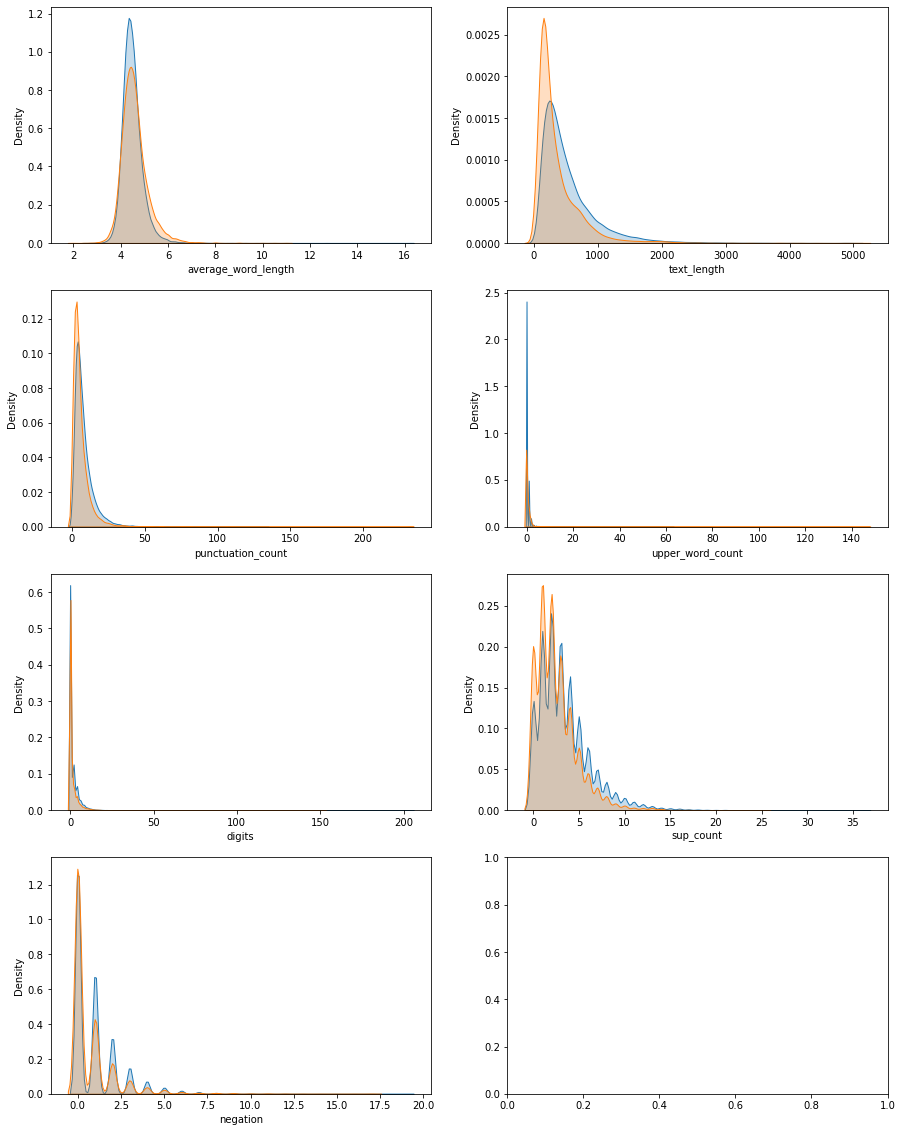

In [63]:
#define subplot to see graphs side by side
fig, ( (ax1,ax2), (ax3, ax4), (ax5,ax6), (ax7, ax8) ) = plt.subplots(4,2, figsize = (15, 20))

#average word length
a=sns.kdeplot(french_reviews['average_word_length'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax1)
a=sns.kdeplot(french_reviews['average_word_length'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax1)

#tweet len
t=sns.kdeplot(french_reviews['text_length'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax2)
t=sns.kdeplot(french_reviews['text_length'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax2)

#word count
e=sns.kdeplot(french_reviews['punctuation_count'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax3)
e=sns.kdeplot(french_reviews['punctuation_count'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax3)

#link count
u=sns.kdeplot(french_reviews['upper_word_count'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax4)
u=sns.kdeplot(french_reviews['upper_word_count'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax4)


#number of digits
d=sns.kdeplot(french_reviews['digits'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax5)
d=sns.kdeplot(french_reviews['digits'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax5)

#superlatives count
s=sns.kdeplot(french_reviews['sup_count'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax6)
s=sns.kdeplot(french_reviews['sup_count'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax6)

#negations
n=sns.kdeplot(french_reviews['negation'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax7)
n=sns.kdeplot(french_reviews['negation'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax7)

#plt.legend()
plt.show()

## Concatenate topics and new features

In [71]:
df_meta = french_reviews.iloc[:, -7:]
df_meta.head()


,text_length,punctuation_count,upper_word_count,average_word_length,digits,negation,sup_count
0,355,7,0,4.220588,1,0,7
1,251,6,1,4.704545,0,1,3
2,320,7,0,4.714286,0,2,2
3,245,5,1,4.326087,2,0,3
4,277,3,0,4.770833,0,0,3


In [122]:
#We split, and we make sure to have the same random_state as the one we used to split the text, this way the data is split the same way.
y = french_reviews['is_fake_review']

X_train_m, X_test_m, y_train, y_test = train_test_split(df_meta, y, 
                                                    test_size = 0.2,
                                                    stratify = y , 
                                                    random_state = 19)
#we use a scaler from sklearn
scaler = StandardScaler()
X_train_m = scaler.fit_transform(X_train_m)
X_test_m = scaler.transform(X_test_m)

In [123]:
X_train_t, X_test_t, y_train, y_test = train_test_split(lsa,y, 
                                                    test_size = 0.2,
                                                    stratify = y , ## Statify splitting when you're training a classification model !
                                                    random_state = 19)

In [117]:
X_train = np.concatenate([X_train_t, X_train_m], axis=1)
X_test = np.concatenate([X_test_t, X_test_m], axis=1)
print(X_train.shape)
print(X_test.shape)

(72477, 307)
(18120, 307)


In [81]:
# grid search class weights with logistic regression for imbalance classification

# define grid
#cw_params = [{0:1, 1:1.8}]
cw_params = [{0:1, 1:i} for i in np.arange(2.0, 4.1, 0.1)]
#C_params = np.arange(0.1, 1.1, 0.1)
C_params = [0.95]
param_grid = dict(class_weight = cw_params, C = C_params)
#param_grid = dict(class_weight = cw_params)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=69)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X_test, y_test)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.425677 using {'C': 0.95, 'class_weight': {0: 1, 1: 3.6000000000000014}}
0.350594 (0.023449) with: {'C': 0.95, 'class_weight': {0: 1, 1: 2.0}}
0.366427 (0.023563) with: {'C': 0.95, 'class_weight': {0: 1, 1: 2.1}}
0.377997 (0.022472) with: {'C': 0.95, 'class_weight': {0: 1, 1: 2.2}}
0.386703 (0.020816) with: {'C': 0.95, 'class_weight': {0: 1, 1: 2.3000000000000003}}
0.393442 (0.020374) with: {'C': 0.95, 'class_weight': {0: 1, 1: 2.4000000000000004}}
0.399444 (0.020989) with: {'C': 0.95, 'class_weight': {0: 1, 1: 2.5000000000000004}}
0.407497 (0.021717) with: {'C': 0.95, 'class_weight': {0: 1, 1: 2.6000000000000005}}
0.411323 (0.021783) with: {'C': 0.95, 'class_weight': {0: 1, 1: 2.7000000000000006}}
0.415001 (0.021448) with: {'C': 0.95, 'class_weight': {0: 1, 1: 2.8000000000000007}}
0.417197 (0.019923) with: {'C': 0.95, 'class_weight': {0: 1, 1: 2.900000000000001}}
0.420745 (0.019142) with: {'C': 0.95, 'class_weight': {0: 1, 1: 3.000000000000001}}
0.422212 (0.018098) with: {'C': 

## Logistic Regression

In [118]:
# Train model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=0.95, class_weight={0:1, 1:3.6}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


model.fit(X_train, y_train)

LogisticRegression(C=0.95, class_weight={0: 1, 1: 3.6})

In [119]:
from sklearn.metrics import f1_score
print('f1 test :',f1_score(y_test, model.predict(X_test)))
print('f1 train :',f1_score(y_train, model.predict(X_train)))

f1 test : 0.43682993483287785
f1 train : 0.4433121684826631


In [88]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

In [90]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79     14643
           1       0.34      0.59      0.43      3477

    accuracy                           0.70     18120
   macro avg       0.61      0.66      0.61     18120
weighted avg       0.78      0.70      0.72     18120



## SVC Model

In [164]:
svc_model = SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0:1, 1:3.6}, coef0=0.0,
                decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
                max_iter=-1, probability=False, random_state=None, shrinking=True,
                tol=0.001, verbose=False)

svc_model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import f1_score
print('f1 test :',f1_score(y_test, svc_model.predict(X_test)))
print('f1 train :',f1_score(y_train, svc_model.predict(X_train)))

## Export vectorizer, topic extractor, preprocessor  with joblib

In [193]:

# Save to file in the current working directory
joblib_file = "text_vectorizer.pkl"
joblib.dump(vectorizer, joblib_file)




['text_vectorizer.pkl']

In [114]:
# Save to file in the current working directory
joblib_file = "topic_extractor.pkl"
joblib.dump(svd, joblib_file)


['topic_extractorlol.pkl']

In [195]:
# Save to file in the current working directory
joblib_file = "main_model.pkl"
joblib.dump(model, joblib_file)

['main_model.pkl']

In [234]:
# Save to file in the current working directory
joblib_file = "preprocessor.pkl"
joblib.dump(preprocessor, joblib_file)

['preprocessor.pkl']